In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
torch.set_default_device(device)

In [3]:

torch.cuda.empty_cache()

In [4]:
PATH = '/groups/francescavitali/eb2/subImages_slide299/H&E' # has 506 images
BATCH_SIZE = 4 # make sure divisble by 404: 1, 2, 4, 101, 202, 404

tensor_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(PATH, 
                               transform = tensor_transform) #loads the images

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                           [404,51,51],# 80%, 10%, 10%
                                                           generator=torch.Generator(device=device))

loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [5]:
len(dataset.targets)

506

In [9]:
model = AE_CNN(32,64).to(device)

#model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state
model.load_state_dict(torch.load('./models/Copy Models/model_gs_3-28-2024.pth'))

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder

RuntimeError: Error(s) in loading state_dict for AE_CNN:
	Missing key(s) in state_dict: "encoder.4.weight", "encoder.4.bias", "encoder.7.weight", "encoder.7.bias", "decoder.1.weight", "decoder.1.bias", "decoder.3.weight", "decoder.3.bias", "decoder.5.weight", "decoder.5.bias". 
	Unexpected key(s) in state_dict: "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([64, 3, 16, 16]) from checkpoint, the shape in current model is torch.Size([64, 3, 8, 8]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([128, 64, 16, 16]) from checkpoint, the shape in current model is torch.Size([32, 64, 8, 8]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).

In [ ]:
count = 0
with torch.no_grad():
    for(img, goal) in loader: # goal will be a tensor of len == batch_size
        if count == 1:
            break
        img = img.to(device)
        print(f'Img Shape: {img.shape}')
        encoded_img = encoder(img)
        print(f'Encoded Shape: {encoded_img.shape}')
        flattened = encoded_img.flatten(start_dim = 1)
        print(f'Flattened: {flattened.shape}')
        print(f'Goal: {goal.unsqueeze(1)}')
        print()
        count += 1

In [ ]:
class NeuralNet(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        
        self.encoder = encoder
        self._feed_forward = torch.nn.Sequential(
            torch.nn.Linear(56448, 8192),
#             torch.nn.ReLU(),
#             torch.nn.Linear(32768, 16384),
#             torch.nn.ReLU(),
#             torch.nn.Linear(16384, 8192),
            torch.nn.ReLU(),
            torch.nn.Linear(8192, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
        )
        self._sigmoid = torch.nn.Sigmoid()

        
    def encoded_without_training(self, x):
        with torch.no_grad():
            self.encoder.eval()
            encoded = self.encoder(x)
            flattened = encoded.flatten(start_dim = 1)
            return flattened
    
    def forward(self,  x):
        self.train()
        encoded = self.encoder(x) # this will update the encoder weights
        flattened = encoded.flatten(start_dim = 1)
#         flattened = self.encoded_without_training(x)
        output = self._feed_forward(flattened)
        return self._sigmoid(output)
    

In [9]:
nn = NeuralNet(encoder).to(device)

In [10]:
lr = 0.00003
weight_decay = 1e-5
EPOCHS = 50

verbose = 2

In [11]:
val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [12]:
optimizer = torch.optim.Adam(nn.parameters(), lr = lr, weight_decay = weight_decay)
loss_function = torch.nn.BCELoss()

loss_arr = []
acc_arr = []
min_loss = None
min_acc = 0
outputs = []
early_stop = False
early_stop_depth = 20

for epoch in range(EPOCHS):
#     if epoch != 0:
#         break

    total_correct = 0
    total_samples = 0
    
    if early_stop:
        if verbose != 0:
            print(f'\n\n------EARLY STOP {min_loss}------\n\n')
        break

    count = 0

    nn.train()
    nn.to(device)
    for (image, label) in loader:
        image = image.to(device)
        label = label.to(device)
        
        #encoded = encoder(image) # TO DO
        output = nn(image)
    
#         print(output)
#         print(label)
        loss = loss_function(output, goal.unsqueeze(1).float())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



        # UI
        if verbose == 2:
            sys.stdout.write('\r')
            sys.stdout.write("Epoch: {} [{:{}}] {:.1f}% | Loss: {}".format(epoch+1, "="*count, 
                                                                       len(loader)-1, 
                                                                       (100/(len(loader)-1)*count), 
                                                                       loss.item()))
            sys.stdout.flush()

        count += 1
        
#         break
#     break
    loss_arr.append(loss.item())
    
    nn.eval()
    total_correct= 0
    for (image_val, label_val) in val_loader:
        nn.eval()
        image_val = image_val.to(device)
        label_val = label_val.to(device)

        with torch.no_grad():

#             _, val_outputs = torch.max(nn(image_val), 1)
            val_outputs = torch.round(nn(image_val))
            total_samples += 1
            total_correct += (val_outputs == label_val).item()
        
    
#     if early_stop_depth >= 1 and early_stop_depth < len(acc_arr[acc_arr.index(min_acc):]):
#         early_stop = True
#         for acc_item in acc_arr[acc_arr.index(min_loss):]:
#             if acc_item < min_acc:
#                 min_acc = acc_item
#                 early_stop = False
    
        
#     if not min_loss:
#         min_loss = loss_arr[0]
#     if early_stop_depth >= 1 and early_stop_depth < len(loss_arr[loss_arr.index(min_loss):]):
#         early_stop = True
#         for loss_item in loss_arr[loss_arr.index(min_loss):]:
#             if loss_item < min_loss:
#                 min_loss = loss_item
#                 early_stop = False

    accuracy = total_correct/len(val_loader)*100
    if verbose != 0:
        print(f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f} | Val Accuracy: {accuracy:.2f}%', end='\n'*2)

Epoch: 1 [====================================================================================================] 100.0% | Loss: 0.523341715335846
Epoch: 1 | Loss: 0.5233 | Val Accuracy: 37.25%

Epoch: 2 [====================================================================================================] 100.0% | Loss: 0.6720530986785889
Epoch: 2 | Loss: 0.6721 | Val Accuracy: 37.25%

Epoch: 3 [====================================================================================================] 100.0% | Loss: 0.5455887317657471
Epoch: 3 | Loss: 0.5456 | Val Accuracy: 37.25%

Epoch: 4 [====================================================================================================] 100.0% | Loss: 0.5480521917343143
Epoch: 4 | Loss: 0.5481 | Val Accuracy: 37.25%

Epoch: 5 [====================================================================================================] 100.0% | Loss: 0.545356035232544
Epoch: 5 | Loss: 0.5454 | Val Accuracy: 37.25%

Epoch: 6 [======================

Epoch: 43 [====================================================================================================] 100.0% | Loss: 0.5688832402229309
Epoch: 43 | Loss: 0.5689 | Val Accuracy: 37.25%

Epoch: 44 [====================================================================================================] 100.0% | Loss: 0.5685583353042603
Epoch: 44 | Loss: 0.5686 | Val Accuracy: 37.25%

Epoch: 45 [====================================================================================================] 100.0% | Loss: 0.5696266889572144
Epoch: 45 | Loss: 0.5696 | Val Accuracy: 37.25%

Epoch: 46 [====================================================================================================] 100.0% | Loss: 0.5694922208786011
Epoch: 46 | Loss: 0.5695 | Val Accuracy: 37.25%

Epoch: 47 [====================================================================================================] 100.0% | Loss: 0.5614756941795349
Epoch: 47 | Loss: 0.5615 | Val Accuracy: 37.25%

Epoch: 48 [=========

In [45]:
#device = torch.device('cpu')
ans = []
pre_sig = []
total_samples = 0
total_correct = 0
nn.to(device)
nn.eval()
for (image, label) in val_loader:
    nn.eval()
    image = image.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        encoded = nn.encoder(image)
        not_rounded = nn._feed_forward(encoded.flatten(start_dim = 1))
        pre_sig.append(not_rounded)
        
        #outputs = torch.round(nn._sigmoid(not_rounded))
        outputs = nn._sigmoid(not_rounded)
        if outputs < 0.5: # 0.779
            outputs = 0
        else:
            outputs = 1
        #_, outputs = torch.max(nn(image), 1) # learn more about the max function i guess?
#         print(outputs)
#         print(label)
        total_samples += 1
        total_correct += (outputs == label).item()
        #ans.append((label.item(), outputs.item()))
        ans.append((label.item(), outputs))

        
print(f'Accuracy: {total_correct/len(val_loader)*100:.2f}%')


Accuracy: 37.25%


In [46]:
ans

[(1, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1)]

In [47]:
sig = []
with torch.no_grad():
    nn.eval()
#     print(val)
#     m = torch.round(val)
#     print(m.item())
    for item in pre_sig:
        val = nn._sigmoid(item)
        sig.append(val.item())

In [48]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7feba85985e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7feba8598b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feba8598310>],
 'medians': [<matplotlib.lines.Line2D at 0x7feba85a6160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feba85a6430>],
 'means': []}

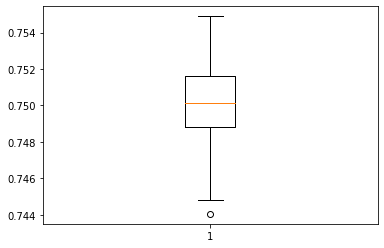

In [49]:
plt.boxplot(sig)

In [50]:
import numpy as np
print(np.quantile(sig,0.25))
print(np.quantile(sig,0.5))
print(np.quantile(sig,0.75))

0.7488048076629639
0.7501294612884521
0.7516307830810547


In [51]:
sig

[0.747343897819519,
 0.7507019639015198,
 0.7499480247497559,
 0.7494971752166748,
 0.7503032684326172,
 0.7440437078475952,
 0.7498912811279297,
 0.7497496008872986,
 0.7512603402137756,
 0.7491387128829956,
 0.7537094950675964,
 0.7498601675033569,
 0.7528034448623657,
 0.7518537044525146,
 0.7512770891189575,
 0.7528281211853027,
 0.7466434836387634,
 0.7517217993736267,
 0.7504539489746094,
 0.7494962811470032,
 0.7521090507507324,
 0.7525534629821777,
 0.7548935413360596,
 0.7492575645446777,
 0.7501294612884521,
 0.7494280338287354,
 0.752791702747345,
 0.7486748099327087,
 0.748934805393219,
 0.7517522573471069,
 0.7511743903160095,
 0.7460236549377441,
 0.7504065036773682,
 0.7539978623390198,
 0.7511477470397949,
 0.7463887929916382,
 0.7494148015975952,
 0.7504492402076721,
 0.7467246055603027,
 0.7480260729789734,
 0.7515397667884827,
 0.7483183741569519,
 0.7502774000167847,
 0.7498040795326233,
 0.7540739178657532,
 0.7480764389038086,
 0.7483838796615601,
 0.7480747699737